In [1]:
#gets necessary classes from the pytorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transform
from torchvision import datasets

#gets numpy to handle formating
import numpy as np

#gets matplotlib to handle imagery
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#sets tranform to convert to tensors
transform = transform.ToTensor()

#download data for training the model and testing and convert it to tensors
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [3]:
#set the number os subprocesses for data loading
num_workers = 0

#set the batch size
batch_size = 20

#load the training and test data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

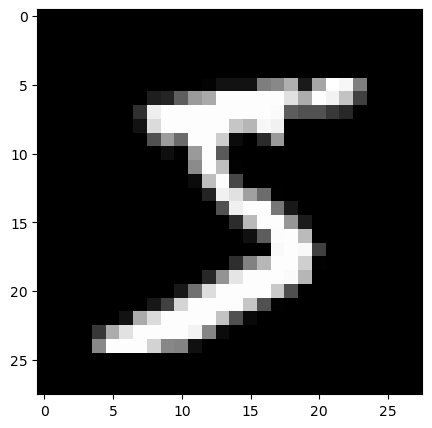

In [4]:
#obtain one batch of images to train
dataiter = iter(train_loader)
images, labels = next(dataiter)

#convert to usable array
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

#display image
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        #add on to inheritance from parent class
        super(Autoencoder, self).__init__()
        
        #encoder
        self.layer1 = nn.Linear(784, 128)
        self.layer2 = nn.Linear(128, encoding_dim)
        
        #decoder
        self.olayer1 = nn.Linear(encoding_dim, 128)
        self.olayer2 = nn.Linear(128, 784)
        
    def forward(self, x):
        #apply relu function to parameters
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.olayer1(x))
        
        #apply sigmoid function to output
        x = torch.sigmoid(self.olayer2(x))
        
        return x      

In [6]:
#set encoding dimension
encoding_dim = 8  

#instatiate a model
model = Autoencoder(encoding_dim)

In [7]:
# specify loss function
criterion = nn.MSELoss()

#specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
#number of epochs when training the model
n_epochs = 5

for epoch in range(1, n_epochs+1):
    #set variable to follow training loss
    train_loss = 0
    
    #training the model
    for data in train_loader:
        #get data
        images, labels = data
        
        #flatten images
        images = images.view(images.size(0), -1)
        
        #clear the gradients of all parameters
        optimizer.zero_grad()
        
        #find predicted outputs
        outputs = model(images)
        
        #calculate the loss
        loss = criterion(outputs, images)
        
        #compute gradient of the loss with respect to parameters
        loss.backward()
        
        #update the parameters
        optimizer.step()
        
        #update training loss
        train_loss += loss.item()*images.size(0)
        
    # print average training loss 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.564640
Epoch: 2 	Training Loss: 0.534250
Epoch: 3 	Training Loss: 0.518265
Epoch: 4 	Training Loss: 0.507637
Epoch: 5 	Training Loss: 0.499804


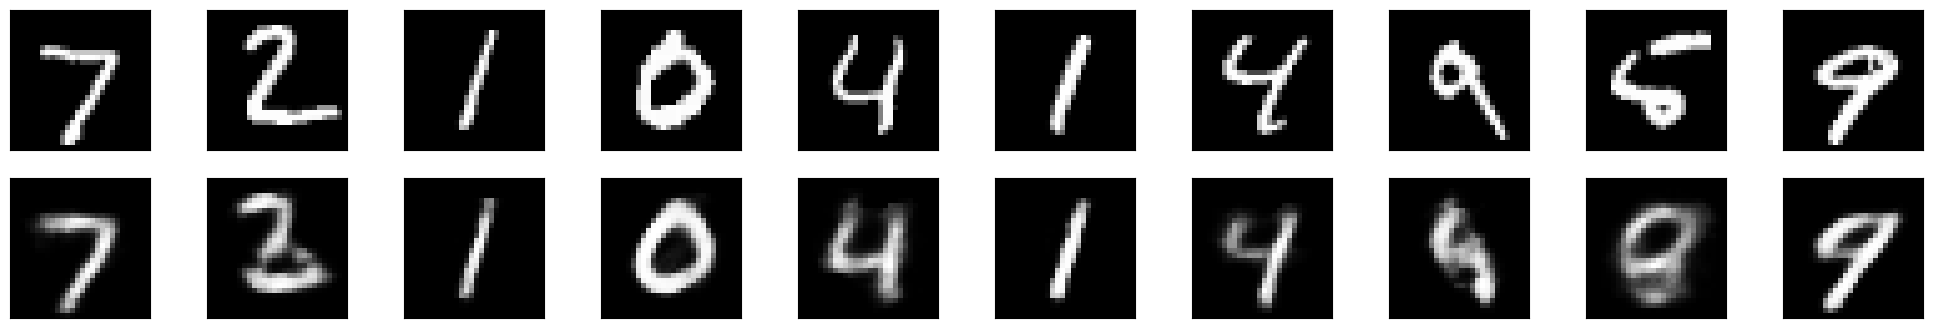

In [11]:
#obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

#flatten the images
images_flatten = images.view(images.size(0), -1)

#get sample outputs
output = model(images_flatten)

#convert images to usable format
images = images.numpy()

#resize images
output = output.view(batch_size, 1, 28, 28)

#use detach when it's an output that requires_grad
output = output.detach().numpy()

#plots 10 images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

#displays input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)